<a href="https://colab.research.google.com/github/totminaekaterina/Coursework_multitasking_learning/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загружаем необходимые данные

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.1 MB/s eta 0:00:00


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          Trainer,
                          TrainingArguments,
                          TrainerCallback,
                          AdamW,
                          get_linear_schedule_with_warmup)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [5]:
device = 'cuda'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [6]:
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [150]:
import chardet
with open('/content/2 STEP (текст).csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}

In [151]:
df = pd.read_csv('/content/2 STEP (текст).csv', encoding='UTF-8-SIG', sep=';')
# Размер нашей выборки
df.shape

(105000, 3)

In [152]:
df.sample(5)

,Unnamed: 0,name,category_1
55204,55206,На Украине осуждены члены преступной группиров...,Украина
93737,93739,Высший хозяйственный суд Украины передал в соб...,Госэкономика
82822,82824,Сотрудничающего с Russia Today британского жур...,Украина
61156,61158,Арабская версия сайта телеканала CNN обнародов...,Общество
55500,55502,На Украине в соответствии с законом о люстраци...,Украина


In [153]:
df.category_1.unique()

array(['Все', 'Украина', 'Футбол', 'Общество', 'Политика', 'Происшествия',
       'Госэкономика'], dtype=object)

In [154]:
# Присвоим каждой категории индекс, чтобы подавать в модель
category_index = {i[1]:i[0] for i in enumerate(df.category_1.unique())}
# обратное преобразование - индекс метки в текст, этот словарь нам понадобится 
# после обучения для большей наглядности, чтобы видеть, к какой категории товар 
# отнесён моделью
category_index_reverce = {i[0]:i[1] for i in enumerate(df.category_1.unique())}

In [155]:
category_index

{'Все': 0,
 'Украина': 1,
 'Футбол': 2,
 'Общество': 3,
 'Политика': 4,
 'Происшествия': 5,
 'Госэкономика': 6}

In [156]:
category_index_reverce

{0: 'Все',
 1: 'Украина',
 2: 'Футбол',
 3: 'Общество',
 4: 'Политика',
 5: 'Происшествия',
 6: 'Госэкономика'}

In [157]:
# Переведём все метки датасета в числа
sentences = df.name.values
labels = [category_index[i] for i in df.category_1.values]

In [158]:
# Каждому предложению (названию товара) теперь соответсвует не название категории, а её индекс:
sentences[22], labels[22]

(' а пять лет спустя был избран на второй срок. На посту президента в 2005 году его сменил Сергей Багапш."',
 0)

In [159]:
# Проверим, что все данные корректны
assert len(sentences) == len(labels) == df.shape[0]

In [160]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [161]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.005)

In [162]:
len(train_sentences), len(test_sentences)

(104475, 525)

In [163]:
print(test_sentences)

['[CLS] Президент Сбербанка Герман Греф пошутил о росте российской экономики, увязав его с вопросом подчинения Росстата. Об этом в среду, 5 апреля, сообщает РИА Новости. По его словам, макроэкономика очень консервативна и поменять в ней что-либо тяжело. «Хотя можно поменять — например, цифра роста будет зависеть от того, кому будет подчиняться Росстат», — приводит агентство слова Грефа. «Но если серьезно, то цифру 2019 года мне бы уже тяжело было прогнозировать, потому что, на мой взгляд, конечно, уже многое будет зависеть от того, какая команда правительства придет в 2018 году. И опять-таки потребуется время, чтобы задать новую инерцию экономике», — добавил президент Сбербанка. Ранее 5 апреля глава Минэкономразвития Максим Орешкин заявил, что экономика России вошла в новую стадию роста. 4 апреля президент России Владимир Путин распорядился передать Росстат в ведение Минэкономразвития. Мера призвана улучшить государственное управление в сфере статистического учета и повысить ее эффекти

In [164]:
from transformers import BertTokenizer, ErnieForMaskedLM
from transformers import BertTokenizer, ErnieForMaskedLM

id='/content/Model_09.02.23/MyDrive/Model 09.02'
tokenizer = BertTokenizer.from_pretrained(id)
model = ErnieForMaskedLM.from_pretrained(id)

Some weights of the model checkpoint at /content/Model_09.02.23/MyDrive/Model 09.02 were not used when initializing ErnieForMaskedLM: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ErnieForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ErnieForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ErnieForMaskedLM were not initialized from the model checkpoint at /content/Model_09.02.23/MyDrive/Model 09.02 and are newly initialized: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
You sho

In [165]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [166]:
# Посмотрим, что получилось
# Сомволы номеров отмечают то, что данный токен - продолжение слова
print(tokenized_texts[42])

['[CLS]', '[UNK]', '«', '[UNK]', '»', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'в', '[UNK]', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', ',', 'а', '[UNK]', 'в', '[UNK]', '.', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'в', '[UNK]', '-', '[UNK]', '«', '[UNK]', '»', '.', 'в', '[UNK]', '[UNK]', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '.', '«', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '.', '[UNK]', 'в', '[UNK]', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '30', '[UNK]', '2015', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'и', '[UNK]', '»', ',', '—', '[UNK]', 'в', '[UNK]', '[UNK]', '.', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '«', '[UNK]', '»', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '.', '[UNK]', '[UNK]', '[UNK]', ',', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[

In [167]:
# ииндексы токенов
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([2.2850e+04, 7.1153e+04, 9.8710e+03, 5.4700e+02, 3.9000e+01,
        1.0000e+01, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   3. ,  164.6,  326.2,  487.8,  649.4,  811. ,  972.6, 1134.2,
        1295.8, 1457.4, 1619. ]),
 <a list of 10 Patch objects>)

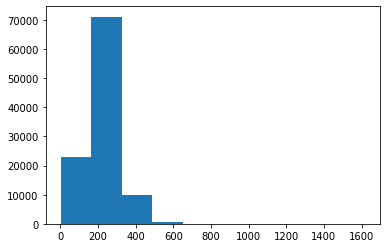

In [168]:
# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [169]:
# Выравниваем датасет. Возьмём размер, равный 24
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=24,
    dtype='long',
    truncating='post',
    padding='post'
)

In [170]:

# Вот, что у нас в результате получилось
# Как видно, в этом примере меньше 24 токенов, поэтому в конец был добавлен паддинг
input_ids[42]
     

array([    1, 39978, 18026, 39978, 18036, 39978, 39978, 39978, 39978,
       18146, 39978,    30, 39978, 39978, 39978, 39978, 39978, 39978,
       39978, 39978, 39978, 39978, 39978, 39978])

In [171]:

# Создадим маску внимания для каждого сэмпла нашей обучающей выборки.
# единицами отметим те токены, которые нужно учитывать при обучении и вычислении градиентов,
# нулями - те, которые следует пропустить.
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [172]:

print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [173]:
# каждая маска соответсвует своей последовательности
assert len(input_ids[42]) == len(attention_masks[42])

In [174]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [175]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

In [176]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [177]:
from torch.utils.data import SequentialSampler

In [178]:
# специальная обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
# также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
# в библиотеке инструментов. Используя их мы существенно сокращаем свой код.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=64
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=64
)

In [179]:
config = AutoConfig.from_pretrained(id,
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

In [180]:
#Загружаем модель, передаём ей наш конфиг
model = AutoModelForSequenceClassification.from_pretrained(id, config=config)

In [181]:
# Отправим на видеокарту, заодно посмотрим архитектуру нашего Берта
model.cuda()

ErnieForSequenceClassification(
  (ernie): ErnieModel(
    (embeddings): ErnieEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=0)
      (position_embeddings): Embedding(2048, 768)
      (token_type_embeddings): Embedding(4, 768)
      (task_type_embeddings): Embedding(3, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ErnieEncoder(
      (layer): ModuleList(
        (0): ErnieLayer(
          (attention): ErnieAttention(
            (self): ErnieSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ErnieSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [182]:
# Гипепараметры модели. Их можно изменять
param_optimizer = list(model.named_parameters())

In [183]:
# Можно посмотреть или изменить. Но нам этого не нужно, инициализируем лишь функцию
# оптимизации. В качестве оптимизатора будем использовать оптимизированный 
# Adam (adaptive moment estimation)
# for name, _ in param_optimizer:
#     print(name)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [184]:
model.to(device)

ErnieForSequenceClassification(
  (ernie): ErnieModel(
    (embeddings): ErnieEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=0)
      (position_embeddings): Embedding(2048, 768)
      (token_type_embeddings): Embedding(4, 768)
      (task_type_embeddings): Embedding(3, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ErnieEncoder(
      (layer): ModuleList(
        (0): ErnieLayer(
          (attention): ErnieAttention(
            (self): ErnieSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ErnieSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [185]:
%%time
train_loss_set = []
train_loss = 0

# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
    optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Обратный прогон
    loss[0].backward()
    
    # Шаг
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')

********************
Лосс на обучении: 1.5441968895140148
CPU times: user 4min 46s, sys: 2min 5s, total: 6min 52s
Wall time: 6min 59s


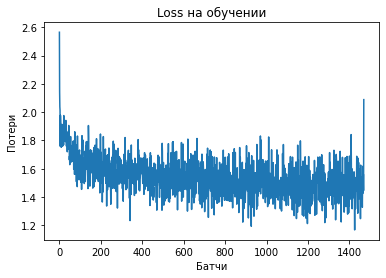

In [186]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.show()

In [187]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    
    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [188]:
print(classification_report(valid_labels, valid_preds, target_names=['Все', 'Политика', 'Общество', 'Украина', 'Происшествия',
       'Госэкономика', 'Футбол']))

              precision    recall  f1-score   support

         Все       0.68      0.55      0.61      1531
    Политика       0.32      0.35      0.34      1488
    Общество       0.71      0.71      0.71      1477
     Украина       0.33      0.11      0.16      1478
Происшествия       0.29      0.39      0.33      1453
Госэкономика       0.52      0.52      0.52      1508
      Футбол       0.39      0.55      0.46      1513

    accuracy                           0.46     10448
   macro avg       0.46      0.46      0.45     10448
weighted avg       0.46      0.46      0.45     10448



Сохранение и загрузка дообученной модели

In [191]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [192]:
model.save_pretrained('/content/drive/MyDrive/10.02.2023')
tokenizer.save_pretrained('/content/drive/MyDrive/10.02.2023')

('/content/drive/MyDrive/10.02.2023/tokenizer_config.json',
 '/content/drive/MyDrive/10.02.2023/special_tokens_map.json',
 '/content/drive/MyDrive/10.02.2023/vocab.txt',
 '/content/drive/MyDrive/10.02.2023/added_tokens.json')

In [194]:
# config
config = AutoConfig.from_pretrained('/content/drive/MyDrive/10.02.2023')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/10.02.2023', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/10.02.2023', config=config)

In [195]:
model

ErnieForSequenceClassification(
  (ernie): ErnieModel(
    (embeddings): ErnieEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=0)
      (position_embeddings): Embedding(2048, 768)
      (token_type_embeddings): Embedding(4, 768)
      (task_type_embeddings): Embedding(3, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ErnieEncoder(
      (layer): ModuleList(
        (0): ErnieLayer(
          (attention): ErnieAttention(
            (self): ErnieSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ErnieSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

In [196]:
%%time

model.to('cpu')
model.eval()

# Выберем несколько случайных названий товаров
skus = [randint(1, len(df)) for p in range(0, 10)]
for sku in skus:
    ground_truth = df.iloc[sku]['category_1']
    sku_title = df.iloc[sku]['name']
    tokens = tokenizer.encode(sku_title, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию товара
    predicted_class = np.argmax(logits, axis=1)

    print(f'Наименование товара: {sku_title}')
    print(f'Предсказанная категория: {category_index_reverce[predicted_class[0]]}')
    print(f'Истинная категория: {ground_truth}')
    print()

Наименование товара: Хорватские полицейские ночью в среду, 23 сентября, пытались вернуть беженцев в Сербию. Об этом сообщило белградское агентство Tanjug со ссылкой на два неназванных источника. Мигрантов планировали тайно переправить через остров Шаренград на Дунае, расположенный недалеко от сербского города Бачка-Паланка. Пограничникам соседней страны удалось предотвратить попытку, используя патрульные катера с прожекторами и мигалками. После инцидента сербы взяли под усиленный контроль этот участок границ, утверждает агентство. Официального подтверждения инцидента ни с одной стороны пока не поступило. Из-за нестабильной ситуации в странах Африки и Ближнего Востока в Европу прибывает все большее число мигрантов. После закрытия южной границы Венгрии миграционный поток направился в Хорватию, беженцы прибывают в основном со стороны Сербии. В четверг, 17 сентября, хорватская полиция перекрыла движение на всех дорогах, ведущих к семи пограничным переходам. Загреб организует передачу бежен